In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
#%matplotlib widget
%matplotlib inline

In [5]:
fin_name = input("Please input dump file for parsing: ")
dump_title = fin_name.split('.')[-1]
fin = open(fin_name, 'r')

recording_time = False
recording_atoms = False
all_rows = [] 

for line in fin:
    if line == 'ITEM: TIMESTEP\n':
        recording_time = True
        recording_atoms = False
        continue
    
    if 'ITEM: ATOMS' in line:
        headers = line.split()[2:]  
        headers.insert(0, 'Timestep') 
        recording_atoms = True
        continue
    
    if recording_time:
        timestep = int(line.strip())  
        recording_time = False
    
    if recording_atoms:
        row = [float(x) for x in line.split()]
        row.insert(0, timestep) 
        all_rows.append(row) 
        
df = pd.DataFrame(all_rows, columns=headers)

if not os.path.exists(dump_title):
    os.makedirs(dump_title)
fout_name = f'{dump_title}_combined.csv'
df.to_csv(f'./{dump_title}/{fout_name}', index=False)

print(f"Data has been written to {fout_name}")

Please input dump file for parsing:  dump.crack


Data has been written to crack_combined.csv


In [2]:
dump_crack = pd.read_csv("crack/crack_combined.csv")

In [3]:
dump_crack

,Timestep,id,type,xs,ys,zs
0,0,1.0,4.0,0.000100,0.000100,0.5
1,0,2.0,4.0,0.005099,0.012597,0.5
2,0,3.0,4.0,0.010098,0.000100,0.5
3,0,4.0,4.0,0.015097,0.012597,0.5
4,0,5.0,4.0,0.020096,0.000100,0.5
...,...,...,...,...,...,...
89546,5000,8037.0,5.0,0.984391,0.988896,0.5
89547,5000,8139.0,5.0,0.979353,1.000130,0.5
89548,5000,8039.0,5.0,0.994487,0.988896,0.5
89549,5000,8140.0,5.0,0.989521,1.000130,0.5


In [4]:
timesteps = dump_crack['Timestep'].unique()
types = dump_crack['type'].unique()
colors = ['red', 'orange', 'green', 'blue', 'purple']

color_mapping = {t: c for t, c in zip(types, colors)} #so I can display the different types of particles when they are plotted

x = dump_crack['xs'].to_numpy()
y = dump_crack['ys'].to_numpy()
z = dump_crack['zs'].to_numpy()

In [5]:
timesteps

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])

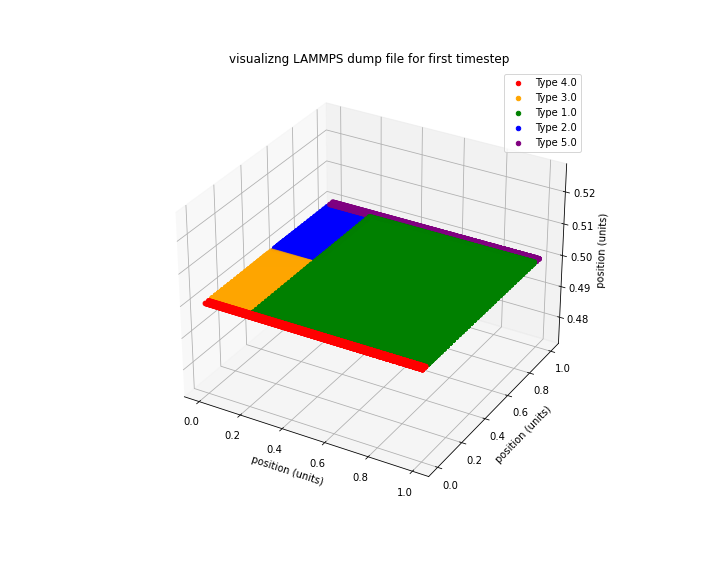

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in types:
    mask = dump_crack['type'] == i
    
    ax.scatter(x[mask], y[mask], z[mask], color=color_mapping[i], label=f'Type {i}')

ax.set_title("visualizng LAMMPS dump file for first timestep")
ax.set_xlabel("position (units)")
ax.set_ylabel("position (units)")
ax.set_zlabel("position (units)")
ax.legend(loc = 'best')

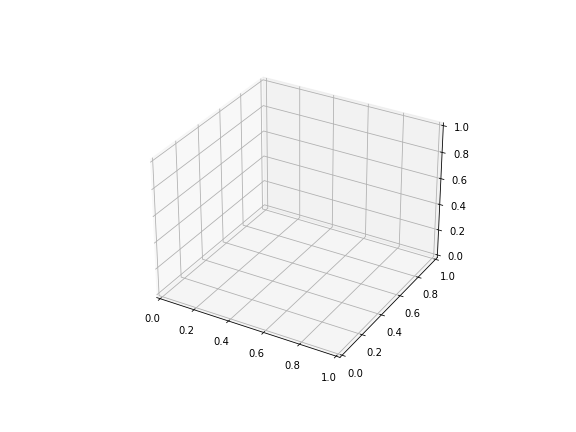

In [10]:
%matplotlib widget
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla() 

    current_data = dump_crack[dump_crack['Timestep'] == timesteps[frame]]

    for i in types:
        mask = current_data['type'] == i
        ax.scatter(current_data['xs'][mask], current_data['ys'][mask], current_data['zs'][mask],
                   color=color_mapping[i], label=f'Type {i}')

    ax.set_title(f"Visualizing LAMMPS dump file for timestep {timesteps[frame]}")
    ax.set_xlabel("Position (units)")
    ax.set_ylabel("Position (units)")
    ax.set_zlabel("Position (units)")
    ax.legend(loc='best')


ani = FuncAnimation(fig, update, frames=len(timesteps), interval=500, repeat=False)
plt.show()

In [9]:
%matplotlib inline


In [10]:
#take a cylinder from timestep a to timestep b where the radius expands radially 
#take this information to make a 3d plot for radius, timestep, and number of particles captured to see if the
#distribution is the sameish or how it varies
#direction vector along axis of the cylinder, get function to find radian distance if extending axis out to some fixed
#length
#we will define the starting point as the starting point of the ion, for this code call it the origin

#for the time steps, define the length of the cylinder as the time step you're looking at +- one time step around
#on each side, UNLESS it is the end or beginning in which we will only look at one in the future or one in the past

#for looping through with radius values, stop the loop when after increasing the radius until we cover the vacancy
#and start to redetect atoms, go 1+ that point of starting to detect atoms outside vacancy range

#for this example file, define the "gold ion" as the particle corresponding to the origin, and make sure

In [88]:
def get_cylinder_points(origin_inp, radius_inp, height_inp, num_points):
    z_values = np.linspace(origin_inp[2] - height_inp / 2, origin_inp[2] + height_inp / 2, num_points)
    thetas = np.linspace(0, 2 * np.pi, num_points)
    
    theta_grid, z_grid = np.meshgrid(thetas, z_values)

    x_grid = origin_inp[0] + radius_inp * np.cos(theta_grid)
    y_grid = origin_inp[1] + radius_inp * np.sin(theta_grid)
    
    return x_grid, y_grid, z_grid

#defining one particle as the origin particle
originx = dump_crack['xs'][44775]
originy = dump_crack['ys'][44775]
originz = dump_crack['zs'][44775]
origin = [originx, originy, originz]

origin_type = dump_crack[dump_crack['type'] == 4]
max_type4, min_type4 = origin_type['ys'].max(), origin_type['ys'].min()

origin_id = dump_crack.loc[44775, 'id']  
radius = ((max_type4 - min_type4) / (2 * 2))  
height = radius * 10  # Track length arbitrarily set to 3 particle diameters


#defining another particle that moves a lot
new_particle_df = dump_crack[dump_crack['type'] == 2.0]

new_particle_x = new_particle_df['xs'][4121]
new_particle_y = new_particle_df['ys'][4121]
new_particle_z = new_particle_df['zs'][4121]
new_particle = [new_particle_x, new_particle_y, new_particle_z]
new_particle_id = dump_crack.loc[4121, 'id']

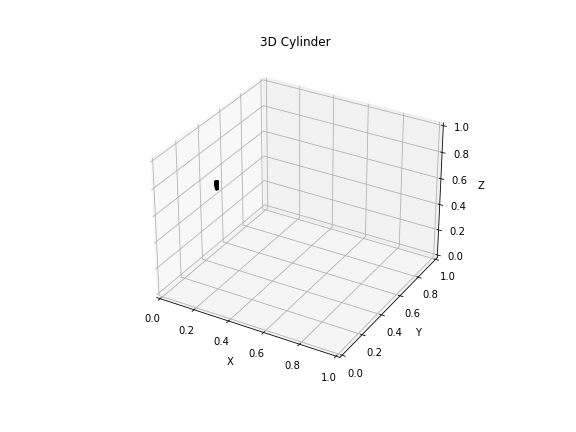

In [92]:
num_points = 100

x, y, z = get_cylinder_points(origin, radius, height, num_points)

x2, y2, z2 = get_cylinder_points(new_particle, radius, height, num_points)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x2, y2, z2, color='cyan', edgecolor='k', alpha=0.7)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Cylinder")
ax.set_xlim(0, 1) 
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()

In [53]:
print(np.unique(x), np.unique(y), np.unique(z))
print(np.unique(x2), np.unique(y2), np.unique(z2))

[0.501356] [0.500151] [0.5]
[0.00509898] [0.512498] [0.5]


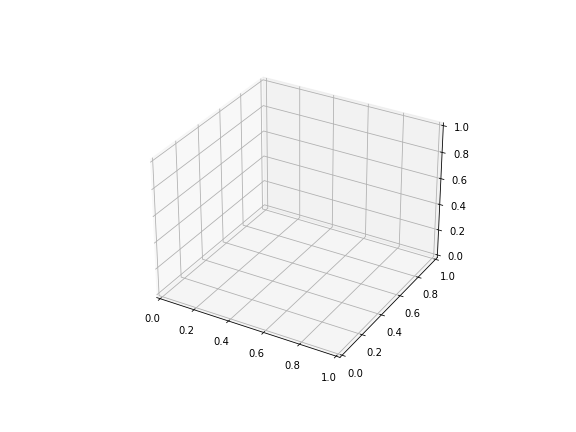

In [108]:
information = []
for timestep in timesteps:
    timestep_data = dump_crack[dump_crack['Timestep'] == timestep]
    origin_particle = timestep_data[timestep_data['id'] == origin_id]
    
    if not origin_particle.empty:
        originx, originy, originz = origin_particle[['xs', 'ys', 'zs']].values[0]
        origin_coord = np.array([originx, originy, originz])
        
        origin_type = timestep_data[timestep_data['type'] == 4]
        max_type4, min_type4 = origin_type['ys'].max(), origin_type['ys'].min()
        radius = ((max_type4 - min_type4) / 2) / 2  
        height = radius * 6  
        
        x_cyl, y_cyl, z_cyl = get_cylinder_points(origin_coord, radius, height, num_points=30)
        
        information.append({
            'Timestep': timestep,
            'Origin_ID': origin_id,
            'xs': origin_coord[0],
            'ys': origin_coord[1],
            'zs': origin_coord[2],
            'x_cyl': x_cyl,
            'y_cyl': y_cyl,
            'z_cyl': z_cyl})

information_df = pd.DataFrame(information)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()  # Clear the axis for new frame
    
    # Get data for the current timestep
    current_data = information_df[information_df['Timestep'] == timesteps[frame]]
    
    # Scatter plot for particles at the current timestep
    ax.scatter(current_data['xs'], current_data['ys'], current_data['zs'], 
               color='mediumvioletred', label='Origin Particle')
    
    ax.plot_wireframe(current_data['x_cyl'].values[0], 
                      current_data['y_cyl'].values[0], 
                      current_data['z_cyl'].values[0], 
                      color='royalblue', alpha=0.5, linewidth=0.5)

    ax.set_title(f"3D Cylinder around Origin Particle - Timestep {timesteps[frame]}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    #ax.set_xlim(0, 1)
    #ax.set_ylim(0, 1)
    #ax.set_zlim(0, 1)

ani = FuncAnimation(fig, update, frames=len(timesteps), interval=500, repeat=False)
plt.show()

### trying to modify the code such that the z-axis is along the direction vector the particle is moving in

In [109]:
# Import necessary modules
import numpy as np
import pandas as pd

# Function to calculate cylinder points based on a specified axis
def get_cylinder_points_along_axis(origin, radius, height, axis, num_points=50):
    # Normalize the axis vector
    axis = axis / np.linalg.norm(axis)
    
    # Generate a set of angles and heights for cylinder coordinates
    z_values = np.linspace(-height / 2, height / 2, num_points)
    thetas = np.linspace(0, 2 * np.pi, num_points)
    
    x_points, y_points, z_points = [], [], []
    
    # Create orthogonal vectors for the cylindrical surface around the axis
    ortho1 = np.cross(axis, [1, 0, 0])
    if np.linalg.norm(ortho1) == 0:
        ortho1 = np.cross(axis, [0, 1, 0])  # Handle special case when axis is along x-axis
    ortho1 = ortho1 / np.linalg.norm(ortho1)
    ortho2 = np.cross(axis, ortho1)

    # Generate cylinder points in 3D along the specified axis
    for z in z_values:
        for theta in thetas:
            # Radial displacement in the plane perpendicular to the axis
            displacement = radius * (np.cos(theta) * ortho1 + np.sin(theta) * ortho2)
            point = origin + z * axis + displacement
            x_points.append(point[0])
            y_points.append(point[1])
            z_points.append(point[2])

    return np.array(x_points), np.array(y_points), np.array(z_points)

# Main data processing with directional alignment
information = []

for i, timestep in enumerate(timesteps):
    timestep_data = dump_crack[dump_crack['Timestep'] == timestep]
    
    # Find the particle's origin data and direction of motion
    origin_particle = timestep_data[timestep_data['id'] == origin_id]
    if not origin_particle.empty:
        originx, originy, originz = origin_particle[['xs', 'ys', 'zs']].values[0]
        origin_coord = np.array([originx, originy, originz])

        # Calculate velocity vector based on the previous timestep (if available)
        if i > 0:
            prev_timestep_data = dump_crack[dump_crack['Timestep'] == timesteps[i-1]]
            prev_origin_particle = prev_timestep_data[prev_timestep_data['id'] == origin_id]
            
            if not prev_origin_particle.empty:
                prev_originx, prev_originy, prev_originz = prev_origin_particle[['xs', 'ys', 'zs']].values[0]
                prev_origin_coord = np.array([prev_originx, prev_originy, prev_originz])
                
                # Calculate the direction vector as the change in position
                direction_vector = origin_coord - prev_origin_coord
            else:
                direction_vector = np.array([0, 0, 1])  # Default direction if no prior data
        else:
            direction_vector = np.array([0, 0, 1])  # Initial timestep default direction

        # Generate cylinder points aligned with the direction vector
        x_cyl, y_cyl, z_cyl = get_cylinder_points_along_axis(origin_coord, radius, height, direction_vector)
        
        # Store information for each timestep
        information.append({
            'Timestep': timestep,
            'Origin_ID': origin_id,
            'xs': origin_coord[0],
            'ys': origin_coord[1],
            'zs': origin_coord[2],
            'x_cyl': x_cyl,
            'y_cyl': y_cyl,
            'z_cyl': z_cyl
        })

# Convert to DataFrame for analysis
information_df = pd.DataFrame(information)
information_df


,Timestep,Origin_ID,xs,ys,zs,x_cyl,y_cyl,z_cyl
0,0,4121.0,0.500000,0.500000,0.5,"[0.5, 0.4992815570615561, 0.498574910936299, 0...","[0.505618227125, 0.5055721015579658, 0.5054344...","[0.483145318625, 0.483145318625, 0.48314531862..."
1,500,4121.0,0.500042,0.499857,0.5,"[0.4952922994598725, 0.49460297338034076, 0.49...","[0.5160285994580587, 0.5158261400500844, 0.515...","[0.505618227125, 0.5055721015579658, 0.5054344..."
2,1000,4121.0,0.500052,0.500160,0.5,"[0.49949604258557206, 0.49877799059821415, 0.4...","[0.48331449034293966, 0.48333818842833115, 0.4...","[0.494381772875, 0.4944278984420341, 0.4945655..."
3,1500,4121.0,0.500495,0.500402,0.5,"[0.48570345692243516, 0.4853590301865001, 0.48...","[0.49232174396214357, 0.49295224414404126, 0.4...","[0.494381772875, 0.4944278984420341, 0.4945655..."
4,2000,4121.0,0.500582,0.500615,0.5,"[0.49420882219898987, 0.49354372040524946, 0.4...","[0.4850117026251025, 0.48528336392113713, 0.48...","[0.494381772875, 0.4944278984420341, 0.4945655..."
5,2500,4121.0,0.501356,0.500151,0.5,"[0.48689993504330514, 0.4865305333818555, 0.48...","[0.5088171681394138, 0.5082009679541508, 0.507...","[0.505618227125, 0.5055721015579658, 0.5054344..."
6,3000,4121.0,0.501615,0.500685,0.5,"[0.4942596587897314, 0.49361323690563924, 0.49...","[0.48551993356647277, 0.4858334602855362, 0.48...","[0.494381772875, 0.4944278984420341, 0.4945655..."
7,3500,4121.0,0.501497,0.500540,0.5,"[0.5121356170781951, 0.5115783762797484, 0.511...","[0.5136128769181197, 0.5140663556368558, 0.514...","[0.505618227125, 0.5055721015579658, 0.5054344..."
8,4000,4121.0,0.499546,0.500489,0.5,"[0.5163949257318226, 0.5163761517299772, 0.516...","[0.5009294383456295, 0.5016476359456357, 0.502...","[0.505618227125, 0.5055721015579658, 0.5054344..."
9,4500,4121.0,0.495998,0.500139,0.5,"[0.5127712664934994, 0.5127007365048694, 0.512...","[0.5017936345188061, 0.5025086070892616, 0.503...","[0.505618227125, 0.5055721015579658, 0.5054344..."


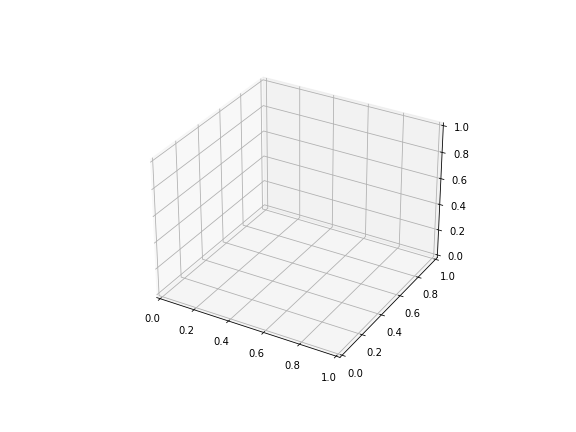

In [110]:
information = []
for timestep in timesteps:
    timestep_data = dump_crack[dump_crack['Timestep'] == timestep]
    origin_particle = timestep_data[timestep_data['id'] == origin_id]
    
    if not origin_particle.empty:
        originx, originy, originz = origin_particle[['xs', 'ys', 'zs']].values[0]
        origin_coord = np.array([originx, originy, originz])
        
        origin_type = timestep_data[timestep_data['type'] == 4]
        max_type4, min_type4 = origin_type['ys'].max(), origin_type['ys'].min()
        radius = ((max_type4 - min_type4) / 2) / 2  
        height = radius * 6  
        
        x_cyl, y_cyl, z_cyl = get_cylinder_points(origin_coord, radius, height, num_points=30)
        
        information.append({
            'Timestep': timestep,
            'Origin_ID': origin_id,
            'xs': origin_coord[0],
            'ys': origin_coord[1],
            'zs': origin_coord[2],
            'x_cyl': x_cyl,
            'y_cyl': y_cyl,
            'z_cyl': z_cyl})

information_df = pd.DataFrame(information)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()  # Clear the axis for new frame
    
    # Get data for the current timestep
    current_data = information_df[information_df['Timestep'] == timesteps[frame]]
    
    # Scatter plot for particles at the current timestep
    ax.scatter(current_data['xs'], current_data['ys'], current_data['zs'], 
               color='mediumvioletred', label='Origin Particle')
    
    ax.plot_wireframe(current_data['x_cyl'].values[0], 
                      current_data['y_cyl'].values[0], 
                      current_data['z_cyl'].values[0], 
                      color='royalblue', alpha=0.5, linewidth=0.5)

    ax.set_title(f"3D Cylinder around Origin Particle - Timestep {timesteps[frame]}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    #ax.set_xlim(0, 1)
    #ax.set_ylim(0, 1)
    #ax.set_zlim(0, 1)

ani = FuncAnimation(fig, update, frames=len(timesteps), interval=500, repeat=False)
plt.show()